In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2023/Conferences.csv
/kaggle/input/march-machine-learning-mania-2023/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2023/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2023/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2023/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2023/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2023/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2023/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2023/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2023/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2023/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-2023/Cities.csv
/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv
/kaggle/input/march-machine-learning-mania-2023/MTeamSpellings.csv
/k

In [2]:
start_data_season = {
    'M': 2003,
    'W': 2009
}

In [3]:
def get_seed_number(seed):
    if 'a' in seed or 'b' in seed:
        return 17
    return int(seed[1:])

def generate_numeric_cols(df, team):
    df[f'{team}FG'] = (df[f'{team}FGM'] * 100) / df[f'{team}FGA']
    df[f'{team}FG3'] = (df[f'{team}FGM3'] * 100) / df[f'{team}FGA3']
    df[f'{team}FT'] = (df[f'{team}FTM'] * 100) / df[f'{team}FTA']

def get_files_by_competition(gender):
    # Getting teams df
    teams_file = f'/kaggle/input/march-machine-learning-mania-2023/{gender}Teams.csv'
    teams_df = pd.read_csv(teams_file)
    display(teams_df)
    
    # Getting regular season games df
    reg_szn_file = f'/kaggle/input/march-machine-learning-mania-2023/{gender}RegularSeasonDetailedResults.csv'
    reg_szn_df = pd.read_csv(reg_szn_file)
    generate_numeric_cols(reg_szn_df, 'W')
    generate_numeric_cols(reg_szn_df, 'L')
    display(reg_szn_df)
    
    # Getting tournament season games df
    tourn_file = f'/kaggle/input/march-machine-learning-mania-2023/{gender}NCAATourneyCompactResults.csv'
    tourn_df = pd.read_csv(tourn_file)
    display(tourn_df)
    
    # Getting seeding df
    seed_file = f'/kaggle/input/march-machine-learning-mania-2023/{gender}NCAATourneySeeds.csv'
    seed_df = pd.read_csv(seed_file)
    seed_df['SeedNum'] = seed_df.Seed.apply(lambda x: get_seed_number(x))
    display(seed_df)
    
    return teams_df, reg_szn_df, tourn_df, seed_df

In [4]:
def get_reg_szn_stats(season, team, reg_szn_df):
    w_games = reg_szn_df[reg_szn_df['WTeamID'] == team].rename(columns = {
        'WFG': 'FG', 'WFG3': 'FG3', 'WFT': 'FT', 'WAst': 'Ast', 'WTO': 'TO', 'WOR': 'OR', 'WDR': 'DR', 'WStl': 'Stl', 'WBlk': 'Blk', 'WPF': 'PF',
        'WScore': 'Score',
        
        'LFG': 'OppFG', 'LFG3': 'OppFG3', 'LFT': 'OppFT', 'LAst': 'OppAst', 'LTO': 'OppTO', 'LOR': 'OppOR', 'LDR': 'OppDR', 'LStl': 'OppStl', 'LBlk': 'OppBlk', 'LPF': 'OppPF',
        'LScore': 'OppScore',
        })
    w_games['Won'] = 1
    
    l_games = reg_szn_df[reg_szn_df['LTeamID'] == team].rename(columns = {
        'LFG': 'FG', 'LFG3': 'FG3', 'LFT': 'FT', 'LAst': 'Ast', 'LTO': 'TO', 'LOR': 'OR', 'LDR': 'DR', 'LStl': 'Stl', 'LBlk': 'Blk', 'LPF': 'PF',
        'LScore': 'Score',
        
        'WFG': 'OppFG', 'WFG3': 'OppFG3', 'WFT': 'OppFT', 'WAst': 'OppAst', 'WTO': 'OppTO', 'WOR': 'OppOR', 'WDR': 'OppDR', 'WStl': 'OppStl', 'WBlk': 'OppBlk', 'WPF': 'OppPF',
        'WScore': 'OppScore',
        })
    l_games['Won'] = 0
    
    games = pd.concat([w_games, l_games], axis=0, ignore_index=True)
    
    reg_szn_pct = (len(w_games) * 100) / len(games)
    
    return [   
               reg_szn_pct, 
               games['Score'].mean(), games['OppScore'].mean(), games['FG'].mean(), games['FG3'].mean(), games['FT'].mean(), games['Ast'].mean(), games['TO'].mean(), 
               games['OR'].mean(), games['DR'].mean(), games['Stl'].mean(), games['Blk'].mean(), games['PF'].mean()
           ]

In [5]:
def get_last_tourn_pct(season, team, tourn_df):
    wins = len(tourn_df[(tourn_df['Season'] == season-1) & (tourn_df['WTeamID'] == team)])
    total_games = len(tourn_df[(tourn_df['Season'] == season-1) & ((tourn_df['WTeamID'] == team) | (tourn_df['LTeamID'] == team))])
    
    if not total_games: return 0
    return (wins * 100) / total_games

In [6]:
def build_dataset(start_data_season, reg_szn_df, tourn_df, seed_df):

    columns = [
                'Season', 'TeamA', 'TeamB', 
                'ASeedNum', 'ALastTournPct', 'ARegSznPct',
                'APts', 'APtsOpp', 'AFG', 'AFG3', 'AFT', 'AAst', 'ATO', 'AOR', 'ADR', 'AStl', 'ABlk', 'APF',
                'BSeedNum', 'BLastTournPct', 'BRegSznPct',
                'BPts', 'BPtsOpp', 'BFG', 'BFG3', 'BFT', 'BAst', 'BTO', 'BOR', 'BDR', 'BStl', 'BBlk', 'BPF',
                'Winner'
              ]
    data = []

    for season in range(start_data_season + 1, 2024):
        tourney_games = tourn_df[tourn_df['Season'] == season].reset_index(drop=True)
        for idx, g in tourney_games.iterrows():

            clear_output(wait=True)
            print(f"{season}: {idx}/{len(tourney_games)}")

            team_a = min([g['WTeamID'], g['LTeamID']])
            team_b = max([g['WTeamID'], g['LTeamID']])

            if team_a == g['WTeamID']:
                winner = 'A'
                team_a_score = g['WScore']
                team_b_score = g['LScore']
            else:
                winner = 'B'
                team_a_score = g['LScore']
                team_b_score = g['WScore']

            print(f"{team_a} x {team_b}")

            a_reg_szn_stats = get_reg_szn_stats(season, team_a, reg_szn_df)
            b_reg_szn_stats = get_reg_szn_stats(season, team_b, reg_szn_df)

            a_seed = seed_df[(seed_df['Season'] == season) & (seed_df['TeamID'] == team_a)].reset_index().loc[0, 'SeedNum']
            b_seed = seed_df[(seed_df['Season'] == season) & (seed_df['TeamID'] == team_b)].reset_index().loc[0, 'SeedNum']

            a_last_tourn_pct = get_last_tourn_pct(season, team_a, tourn_df)
            b_last_tourn_pct = get_last_tourn_pct(season, team_b, tourn_df)

            stats_a = [a_seed, a_last_tourn_pct] + (a_reg_szn_stats)
            stats_b = [b_seed, b_last_tourn_pct] + (b_reg_szn_stats)

            data.append([season, team_a, team_b] + stats_a + stats_b + [winner])

    data_df = pd.DataFrame(data, columns=columns)
    display(data_df)
    
    return data_df

In [7]:
def train_model(x_train, y_train):
    classifier = RandomForestClassifier(random_state=0)
    classifier.fit(x_train, y_train)
    return classifier

def predict_seasons(gender, start_data_season, data_df):

    acc_sum = 0
    seasons_count = 0

    for season in range(start_data_season + 2, 2024):
        data_train = data_df[(data_df['Season'] < season)].reset_index(drop=True)
        data_test = data_df[(data_df['Season'] == season)].reset_index(drop=True)

        if not len(data_test):
            continue

        x_train = data_train.drop(['Winner'], axis=1)
        y_train = data_train.loc[:, 'Winner']
            
        classifier = train_model(x_train, y_train)

        x_test = data_test.drop(['Winner'], axis=1)
        y_test = data_test.loc[:, 'Winner']

        predictions = classifier.predict(x_test)

        print(f'\nResults for {gender} season {season}:')
        acc = accuracy_score(y_test, predictions)
        print('Accuracy predictions:', acc)

        acc_sum += acc
        seasons_count += 1

        cm = confusion_matrix(y_test, predictions)
        print('Confusion matrix:')
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
        cm_disp.plot()
        plt.show()

    print(f'\n\n{gender} Mean Accuracy: {acc_sum/seasons_count}')


In [8]:
def pipeline(gender):
    teams_df, reg_szn_df, tourn_df, seed_df = get_files_by_competition(gender)
    data_df = build_dataset(start_data_season[gender], reg_szn_df, tourn_df, seed_df)
    predict_seasons(gender, start_data_season[gender], data_df)

2022: 66/67
1242 x 1314


,Season,TeamA,TeamB,ASeedNum,ALastTournPct,ARegSznPct,APts,APtsOpp,AFG,AFG3,...,BFG3,BFT,BAst,BTO,BOR,BDR,BStl,BBlk,BPF,Winner
0,2004,1197,1250,17,0.000000,34.323432,65.089109,72.562706,41.220948,32.378705,...,36.157139,73.194370,13.175698,13.152709,9.239737,24.995074,6.180624,2.827586,17.720854,A
1,2004,1104,1356,8,0.000000,60.242792,71.825493,67.534143,44.422728,33.656733,...,34.386551,68.868213,12.111455,12.945820,9.681115,22.136223,7.094427,2.712074,18.207430,A
2,2004,1163,1436,2,66.666667,67.119155,73.461538,65.865762,44.927783,34.964972,...,35.703908,70.415087,13.465944,12.580495,10.160991,25.134675,5.976780,3.518576,16.862229,A
3,2004,1173,1177,10,0.000000,67.427702,70.257230,64.788432,46.077877,35.948077,...,32.796628,67.910935,13.034646,13.239370,11.365354,22.908661,6.645669,3.601575,18.077165,B
4,2004,1106,1181,16,0.000000,40.691928,64.792422,68.822076,40.680483,31.998595,...,37.180798,72.094828,14.585903,12.217327,12.032305,24.839941,7.591777,4.826725,17.107195,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2022,1242,1274,1,50.000000,81.979321,77.605613,65.762186,48.079416,36.868958,...,35.169162,71.042099,12.460949,12.252680,11.062787,23.856049,6.681470,3.777948,16.090352,A
1180,2022,1314,1389,8,0.000000,72.647059,80.404412,70.641176,46.202527,34.793957,...,33.527086,67.509980,11.424765,13.954545,11.462382,22.938871,7.134796,3.846395,18.963950,A
1181,2022,1242,1437,1,50.000000,81.979321,77.605613,65.762186,48.079416,36.868958,...,35.953998,75.479023,13.883686,12.267372,11.148036,24.475831,6.883686,3.392749,17.560423,A
1182,2022,1181,1314,2,0.000000,80.469897,79.649046,67.002937,47.030392,37.180798,...,34.793957,70.511862,16.825000,13.279412,13.776471,27.101471,7.238235,4.366176,16.445588,B



Results for M season 2005:
Accuracy predictions: 0.703125
Confusion matrix:


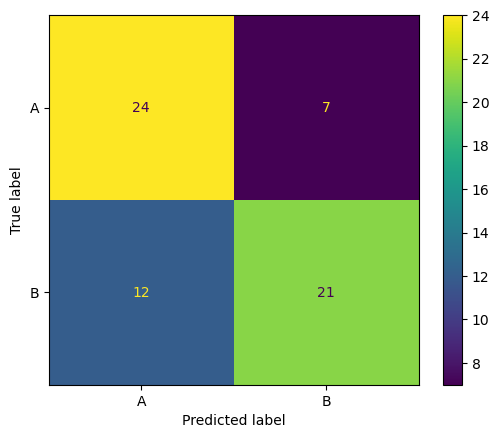


Results for M season 2006:
Accuracy predictions: 0.640625
Confusion matrix:


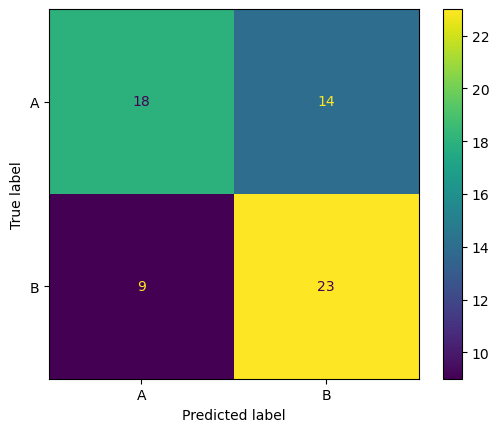


Results for M season 2007:
Accuracy predictions: 0.765625
Confusion matrix:


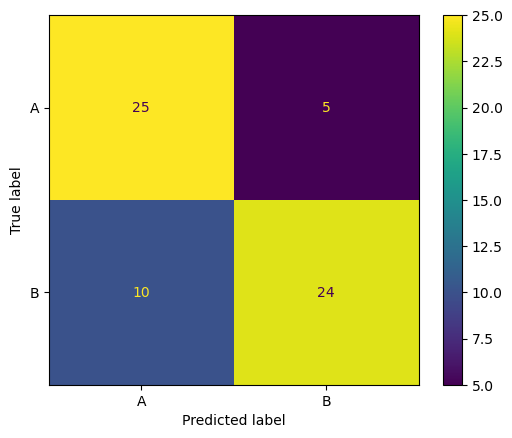


Results for M season 2008:
Accuracy predictions: 0.765625
Confusion matrix:


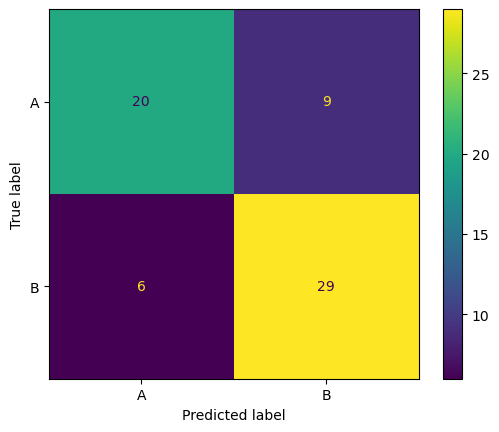


Results for M season 2009:
Accuracy predictions: 0.671875
Confusion matrix:


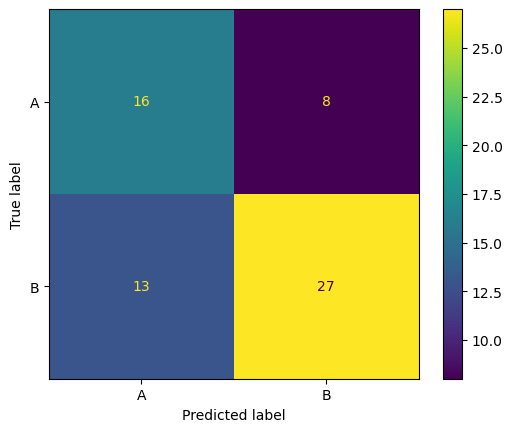


Results for M season 2010:
Accuracy predictions: 0.671875
Confusion matrix:


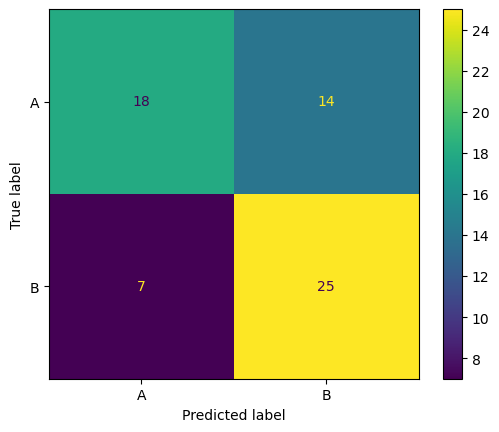


Results for M season 2011:
Accuracy predictions: 0.6119402985074627
Confusion matrix:


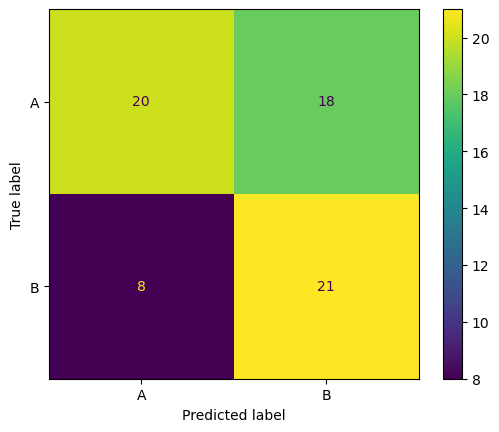


Results for M season 2012:
Accuracy predictions: 0.7014925373134329
Confusion matrix:


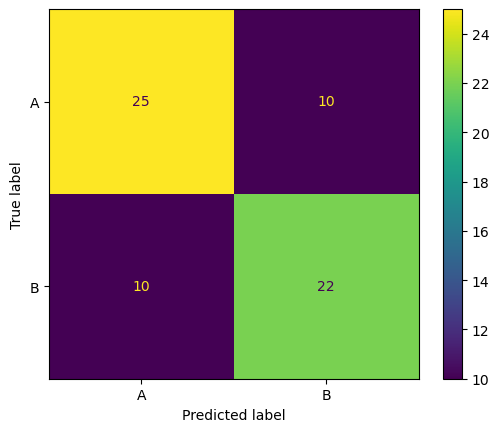


Results for M season 2013:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


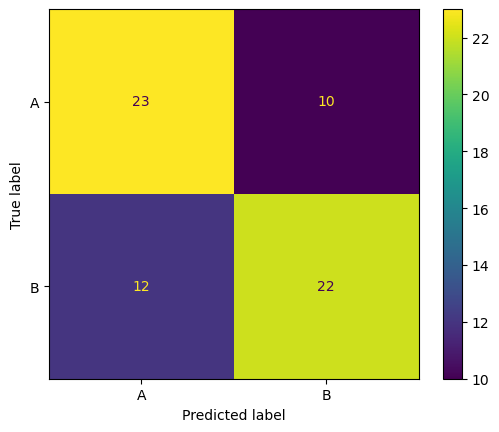


Results for M season 2014:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


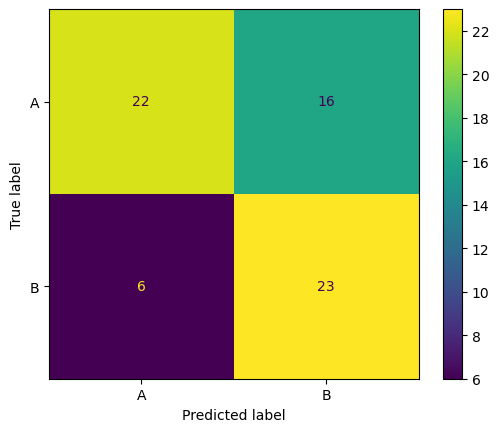


Results for M season 2015:
Accuracy predictions: 0.7611940298507462
Confusion matrix:


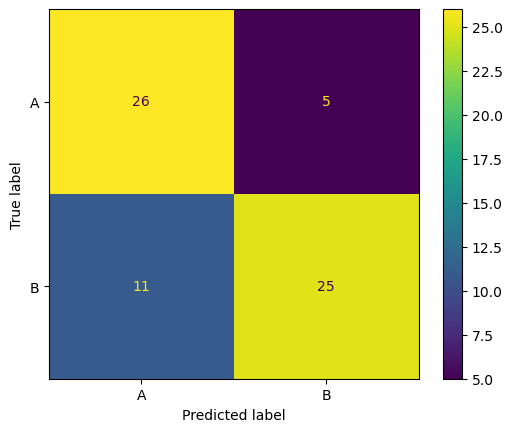


Results for M season 2016:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


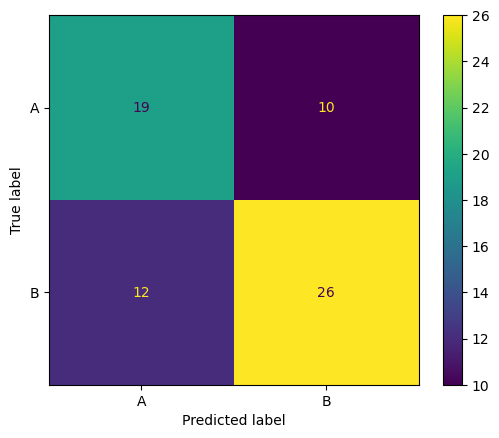


Results for M season 2017:
Accuracy predictions: 0.7313432835820896
Confusion matrix:


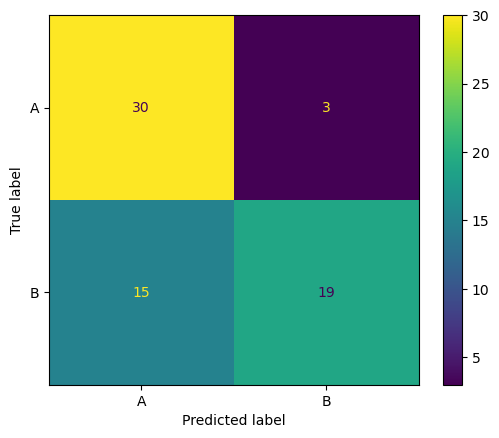


Results for M season 2018:
Accuracy predictions: 0.6865671641791045
Confusion matrix:


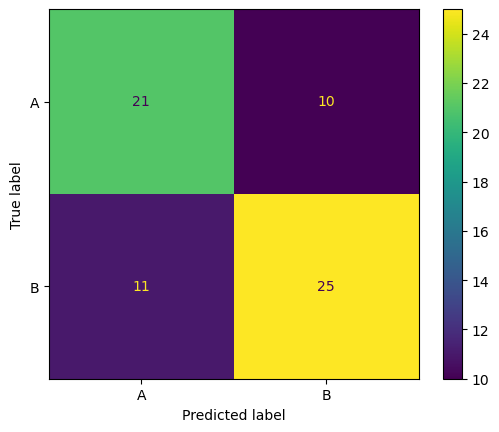


Results for M season 2019:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


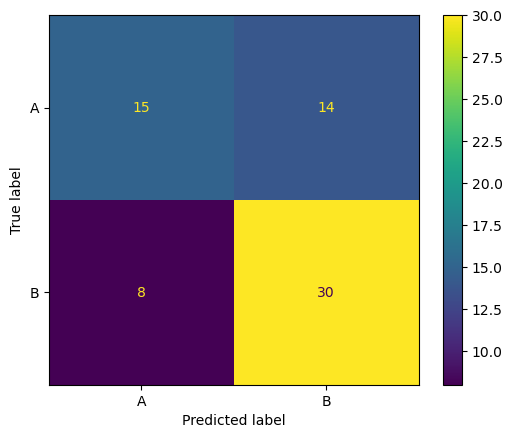


Results for M season 2021:
Accuracy predictions: 0.6515151515151515
Confusion matrix:


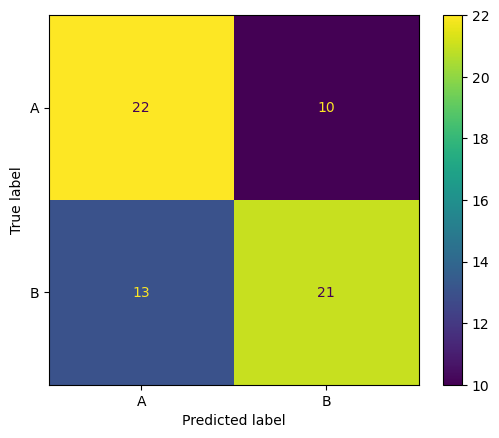


Results for M season 2022:
Accuracy predictions: 0.7164179104477612
Confusion matrix:


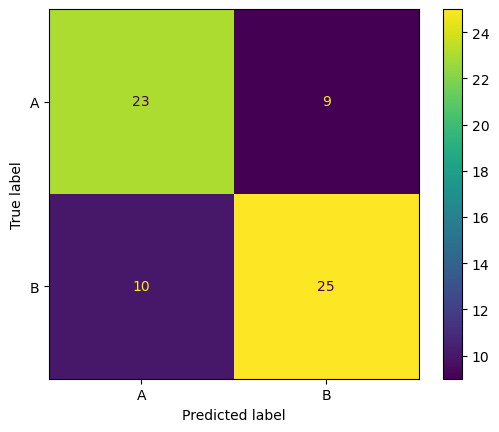



M Mean Accuracy: 0.6921051493867562


In [9]:
pipeline('M')

2022: 66/67
3163 x 3376


,Season,TeamA,TeamB,ASeedNum,ALastTournPct,ARegSznPct,APts,APtsOpp,AFG,AFG3,...,BFG3,BFT,BAst,BTO,BOR,BDR,BStl,BBlk,BPF,Winner
0,2010,3124,3201,4,66.666667,89.508929,80.104911,56.187500,48.101057,35.611117,...,32.771686,71.622027,13.947619,14.400000,11.635714,24.433333,9.271429,2.909524,15.233333,A
1,2010,3173,3395,8,0.000000,71.321696,70.341646,61.700748,41.081369,33.828400,...,32.878260,70.870003,13.824940,15.369305,11.182254,24.575540,8.748201,4.388489,17.443645,A
2,2010,3181,3214,2,50.000000,74.692875,70.417690,57.712531,44.481208,35.214389,...,29.186609,66.667112,12.065854,14.907317,13.960976,23.285366,10.258537,3.265854,18.592683,A
3,2010,3199,3256,3,50.000000,71.904762,73.490476,61.916667,44.352838,33.489294,...,31.179657,70.309662,13.176329,16.222222,12.176329,25.227053,7.753623,2.584541,17.601449,A
4,2010,3207,3265,5,0.000000,46.191646,62.105651,63.066339,38.085158,29.342821,...,32.549984,74.605731,14.692841,13.623557,9.263279,25.727483,7.200924,3.570439,13.168591,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2022,3163,3301,2,80.000000,94.196429,81.890625,50.796875,50.543461,36.758676,...,33.588629,70.880467,14.034965,15.074592,12.944056,26.864802,7.582751,3.193473,15.685315,A
756,2022,3257,3276,1,75.000000,78.054299,73.438914,59.694570,44.822159,34.128261,...,35.262331,73.064181,15.057971,15.101449,11.676329,24.968599,7.251208,3.043478,14.968599,A
757,2022,3163,3390,2,80.000000,94.196429,81.890625,50.796875,50.543461,36.758676,...,34.595779,70.984490,15.384270,13.204494,13.000000,28.692135,6.880899,5.116854,14.703371,A
758,2022,3257,3376,1,75.000000,78.054299,73.438914,59.694570,44.822159,34.128261,...,31.438940,65.858537,13.721578,14.129930,14.470998,26.556845,7.835267,5.921114,15.211137,B



Results for W season 2011:
Accuracy predictions: 0.7142857142857143
Confusion matrix:


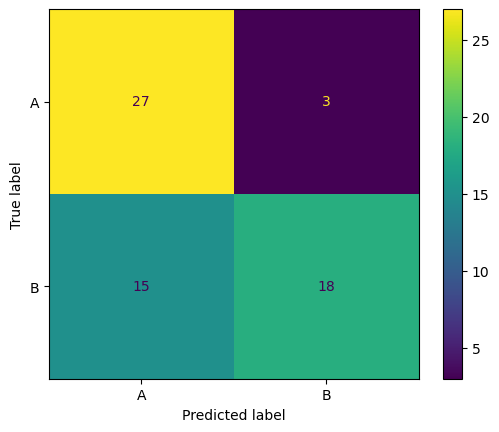


Results for W season 2012:
Accuracy predictions: 0.746031746031746
Confusion matrix:


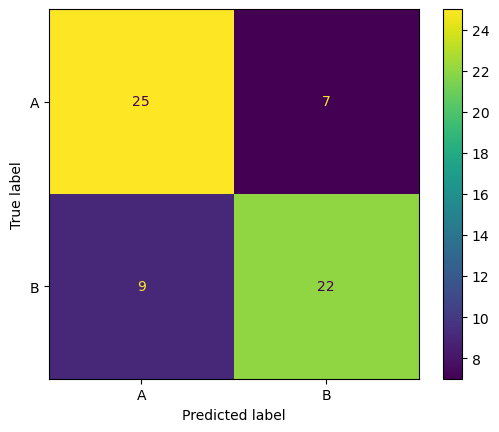


Results for W season 2013:
Accuracy predictions: 0.7301587301587301
Confusion matrix:


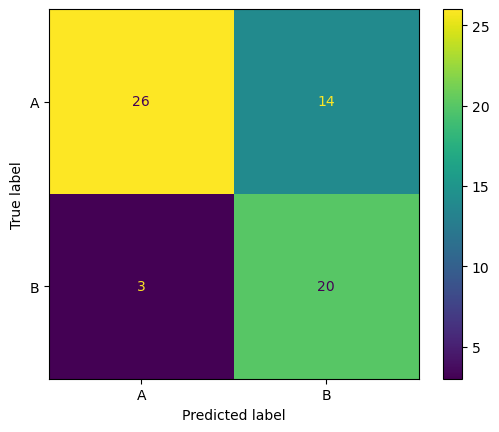


Results for W season 2014:
Accuracy predictions: 0.8095238095238095
Confusion matrix:


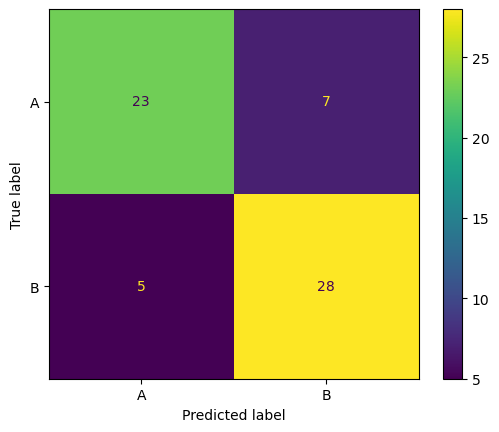


Results for W season 2015:
Accuracy predictions: 0.8095238095238095
Confusion matrix:


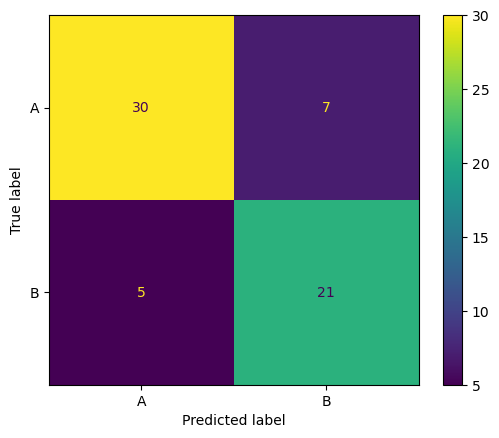


Results for W season 2016:
Accuracy predictions: 0.6825396825396826
Confusion matrix:


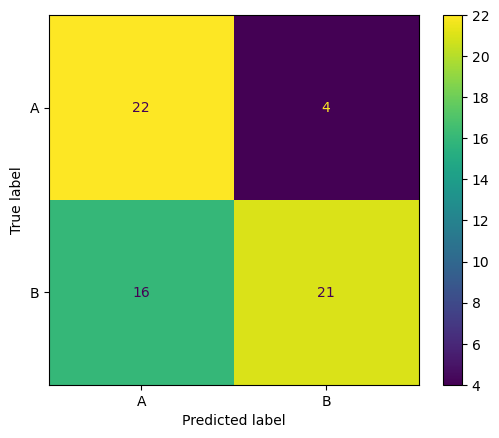


Results for W season 2017:
Accuracy predictions: 0.746031746031746
Confusion matrix:


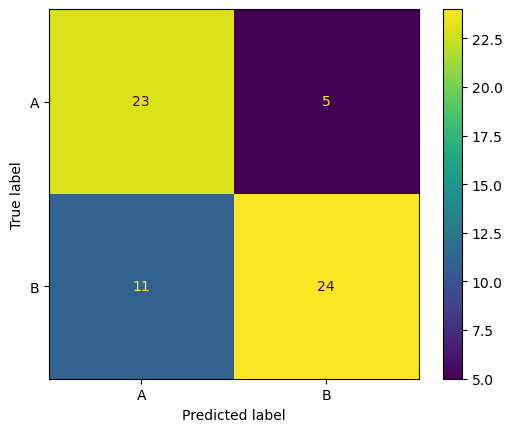


Results for W season 2018:
Accuracy predictions: 0.746031746031746
Confusion matrix:


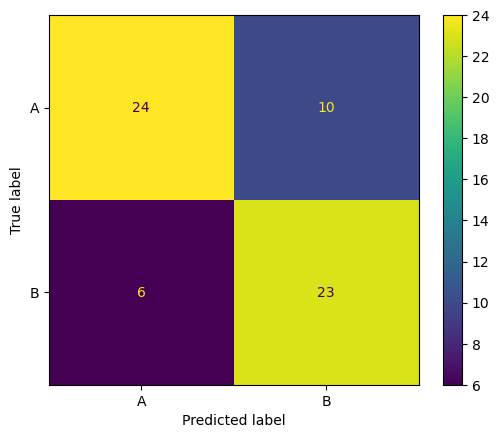


Results for W season 2019:
Accuracy predictions: 0.7619047619047619
Confusion matrix:


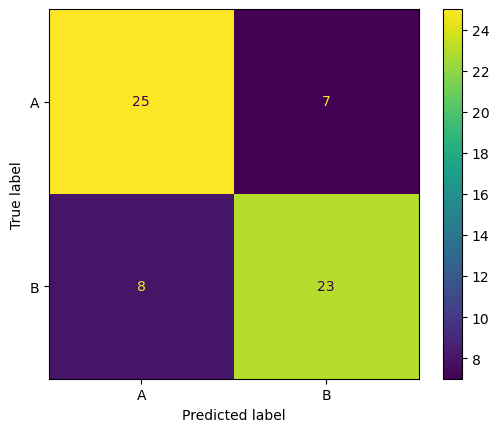


Results for W season 2021:
Accuracy predictions: 0.7142857142857143
Confusion matrix:


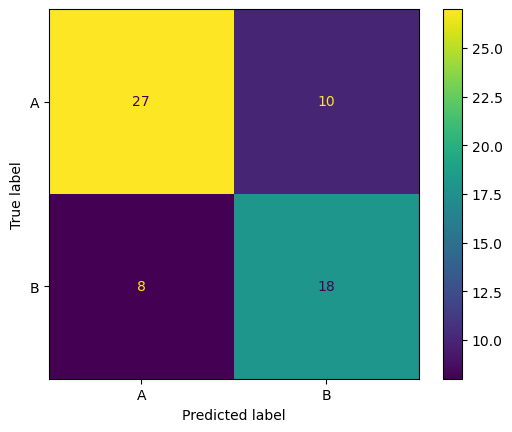


Results for W season 2022:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


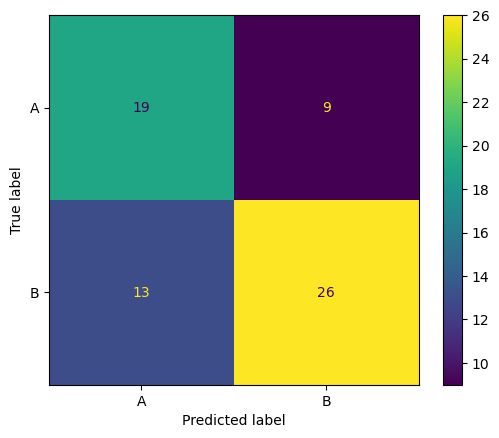



W Mean Accuracy: 0.7392690228511124


In [10]:
pipeline('W')